In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB0
import seaborn
from tensorflow.math import confusion_matrix
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Rescaling

In [11]:
!kaggle datasets download -d kaustubhb999/tomatoleaf
!unzip *.zip

Streaming output truncated to the last 5000 lines.
  inflating: tomato/train/Tomato___Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0044d10f-7062-4655-8abd-9fffc5b2f152___Com.G_TgS_FL 7908.JPG  
  inflating: tomato/train/Tomato___Target_Spot/00854623-ba28-446d-a1d5-03c0ae3f99d9___Com.G_TgS_FL 7949.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118c27a-f34a-41e1-8b2f-d2c564f83c5c___Com.G_TgS_FL 0013.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118ed61-b135-45be-ad81-7e2d54203be4___Com.G_TgS_FL 8241.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0197df47-a9cb-4b6c-b72c-ac0e9af6d135___Com.G_TgS_FL 0779.JPG  
  inflating: tomato/train/Tomato___Target_Spot/025510ac-15db-4861-b02b-21da82161100___Com.G_TgS_FL 0952.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0288164e-d6cf-4215-b593-7b581308a4cf___Com.G_TgS_FL 9777.JPG  
  inflating: tomato/train/Tomato___Target_Spot/03002b91-afe3-4c72-86b

In [12]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 30

# **Data exploration**

In [14]:
ds = image_dataset_from_directory(
    '/content/tomato/train',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)
ds_val = image_dataset_from_directory(
    '/content/tomato/val',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [15]:
ds.class_names, ds_val.class_names

(['Tomato___Bacterial_spot',
  'Tomato___Early_blight',
  'Tomato___Late_blight',
  'Tomato___Leaf_Mold',
  'Tomato___Septoria_leaf_spot',
  'Tomato___Spider_mites Two-spotted_spider_mite',
  'Tomato___Target_Spot',
  'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
  'Tomato___Tomato_mosaic_virus',
  'Tomato___healthy'],
 ['Tomato___Bacterial_spot',
  'Tomato___Early_blight',
  'Tomato___Late_blight',
  'Tomato___Leaf_Mold',
  'Tomato___Septoria_leaf_spot',
  'Tomato___Spider_mites Two-spotted_spider_mite',
  'Tomato___Target_Spot',
  'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
  'Tomato___Tomato_mosaic_virus',
  'Tomato___healthy'])

In [16]:
len(ds)

313

# **Spliting Dataset to train and test**

In [17]:
size = int(len(ds) * 0.8)
ds_train = ds.take(size)
ds_test = ds.skip(size)

In [18]:
len(ds_train), len(ds_test), len(ds_val)

(250, 63, 32)

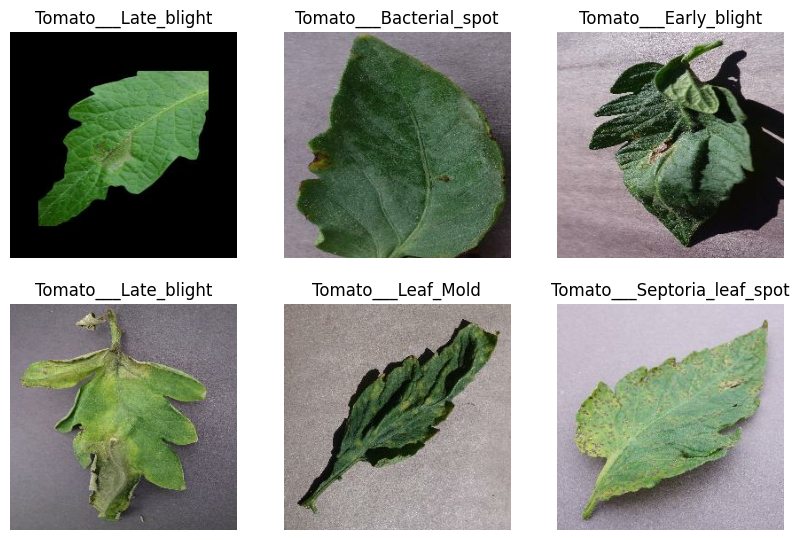

In [19]:
plt.figure(figsize=(10, 10))
for img, label in ds_train.take(1):
    for i in range(6):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(ds.class_names[label[i].numpy()])
        plt.axis('OFF')

# **Fine-tuning with EfficientNetB0**

In [21]:
model_EfficientNetB0 = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
model_EfficientNetB0.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [23]:
model_EfficientNetB0.trainable = False

In [24]:
x = Flatten()(model_EfficientNetB0.output)
prediction = Dense(10, activation='softmax')(x)
model_finetune = Model(inputs=model_EfficientNetB0.input, outputs=prediction)

In [25]:
model_finetune.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='Adam',
    metrics=['accuracy']
    )

In [26]:
finetune_result = model_finetune.fit(
    ds_train,
    epochs=EPOCHS - 15,
    validation_data=ds_val
)

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - accuracy: 0.6762 - loss: 3.2378 - val_accuracy: 0.8300 - val_loss: 1.8180
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9260 - loss: 0.4837 - val_accuracy: 0.8270 - val_loss: 2.2521
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9405 - loss: 0.5122 - val_accuracy: 0.8550 - val_loss: 2.3843
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9660 - loss: 0.2496 - val_accuracy: 0.8810 - val_loss: 1.9563
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9764 - loss: 0.1739 - val_accuracy: 0.8820 - val_loss: 2.1586
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9724 - loss: 0.2442 - val_accuracy: 0.8400 - val_loss: 3.1270
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9737 - loss: 0.2294 - val_accuracy: 0.8620 - val_loss: 3.3253
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9723 - loss: 0.2725 -

# **Showing EfficientNetB0 Accuracy**

In [30]:
ftm_train_acc = finetune_result.history['accuracy']
ftm_val_acc = finetune_result.history['val_accuracy']

ftm_train_loss = finetune_result.history['loss']
ftm_val_loss = finetune_result.history['val_loss']

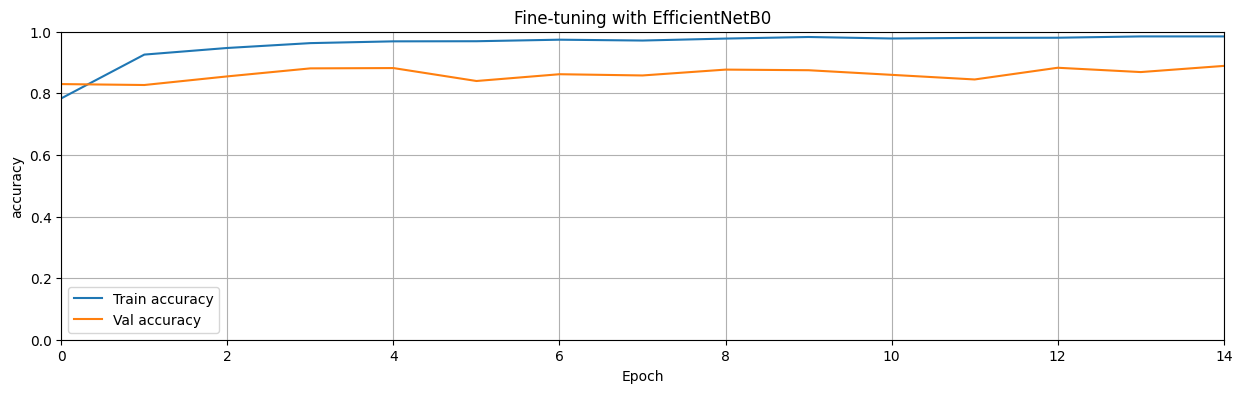

In [54]:
fig, ax = plt.subplots(figsize=(15, 4))
for idx, (metric, label) in enumerate(zip([ftm_train_acc, ftm_val_acc], ['Train accuracy', 'Val accuracy'])):
  ax.plot(metric, label=label)
ax.legend()
plt.title('Fine-tuning with EfficientNetB0')
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.xlim([0, EPOCHS - 16])
plt.ylim([0.0, 1.0])
plt.grid(True)

# **Fine-tuning with VGG16**

In [37]:
model_VGG16 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
model_VGG16.summary()
model_VGG16.trainable = False
x = Flatten()(model_VGG16.output)
prediction = Dense(10, activation='softmax')(x)
model_finetune_VGG16 = Model(inputs=model_VGG16.input, outputs=prediction)
model_finetune_VGG16.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='Adam',
    metrics=['accuracy']
    )
finetune_VGG16_result = model_finetune.fit(
    ds_train,
    epochs=EPOCHS - 15,
    validation_data=ds_val
)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9859 - loss: 0.1851 - val_accuracy: 0.8920 - val_loss: 3.9818
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.9910 - loss: 0.1233 - val_accuracy: 0.8710 - val_loss: 4.8468
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.9898 - loss: 0.1338 - val_accuracy: 0.8650 - val_loss: 5.1870
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9853 - loss: 0.2289 - val_accuracy: 0.8820 - val_loss: 5.2624
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.9879 - loss: 0.1459 - val_accuracy: 0.8860 - val_loss: 4.8976
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.9861 - loss: 0.2340 - val_accuracy: 0.8880 - val_loss: 5.3784
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9863 - loss: 0.2296 - val_accuracy: 0.8880 - val_loss: 4.9553
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9881 - loss: 0.1726 - 

In [38]:
ftmVGG16_train_acc = finetune_VGG16_result.history['accuracy']
ftmVGG16_val_acc = finetune_VGG16_result.history['val_accuracy']

# **Showing VGG16 Accuracy**

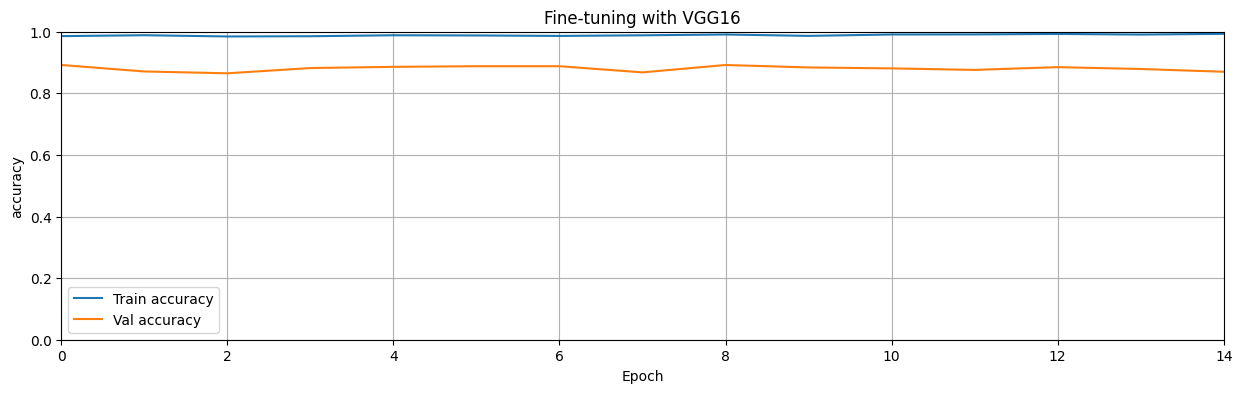

In [52]:
fig, ax = plt.subplots(figsize=(15, 4))
for idx, (metric, label) in enumerate(zip([ftmVGG16_train_acc, ftmVGG16_val_acc], ['Train accuracy','Val accuracy'])):
  ax.plot(metric, label=label)
ax.legend()
plt.title('Fine-tuning with VGG16')
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.xlim([0, EPOCHS - 16])
plt.ylim([0.0, 1.0])
plt.grid(True)

# **Compaire VGG16 and EfficientNetB0 Accuracy**

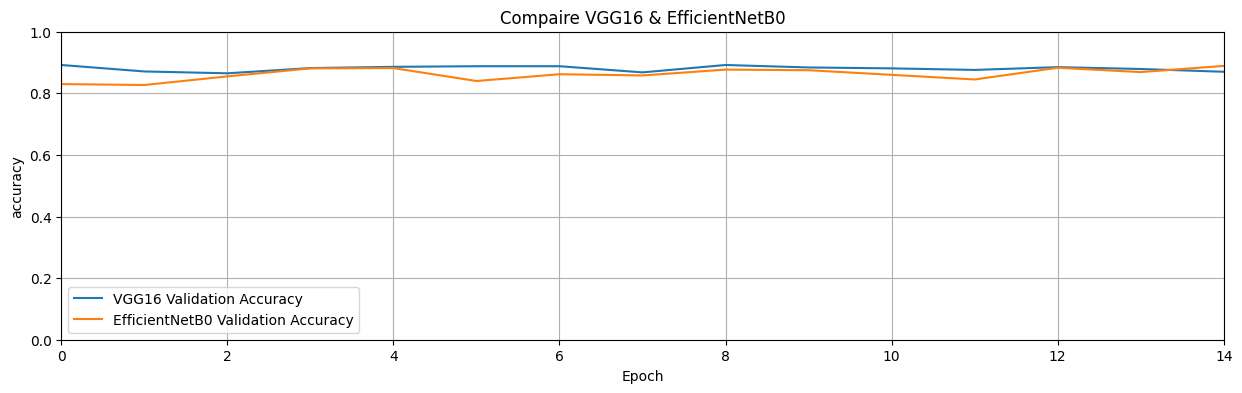

In [55]:
fig, ax = plt.subplots(figsize=(15, 4))
for idx, (metric, label) in enumerate(zip([ftmVGG16_val_acc, ftm_val_acc], ['VGG16 Validation Accuracy', 'EfficientNetB0 Validation Accuracy'])):
    ax.plot(metric, label=label)
plt.title('Compaire VGG16 & EfficientNetB0')
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.xlim([0, EPOCHS - 16])
plt.ylim([0.0, 1.0])
ax.legend()
plt.grid(True)

# **confusion matrix for EfficientNetB0 Model**

In [56]:
y_pred = []
y_true = []
for img, label in ds_test.take(2):
    for i in range(BATCH_SIZE):
        pred = model_finetune.predict(img.numpy())
        y_pred.append(np.argmax(pred[i]))
        y_true.append(label[i].numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━

<Axes: >

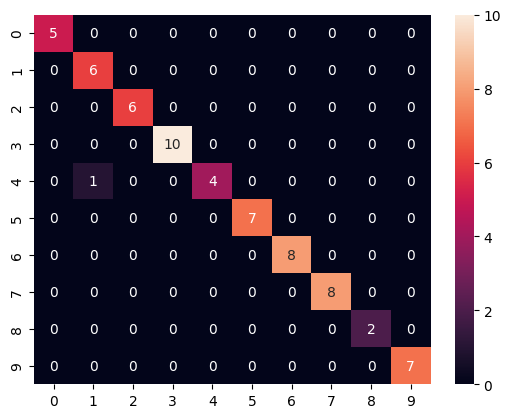

In [57]:
cm = confusion_matrix(y_true, y_pred)
seaborn.heatmap(cm, annot=True, fmt="d")

# **Export EfficientNetB0 Model**

In [45]:
model_finetune.save('efficientnet_tomato_leaf_model.keras')

In [46]:
model_finetune.export('efficientnet_tomato_leaf_mode')

Saved artifact at 'efficientnet_tomato_leaf_mode'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_19')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138006288961552: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138006288964016: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138006288966480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138006288967008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138006288970880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138006288968592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138006288968768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138006288972640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138006265725168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138006265727104: TensorSpec(shape=(), dtype=tf.re